In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# Load train and test data
train_data = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test_data = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

# Data Preprocessing
# Separate features and target
X_train = train_data.drop(columns=['Rating'])
y_train = train_data['Rating']
X_test = test_data



Summary statistics of numerical columns:
                 ID  RecipeNumber     RecipeCode  UserReputation  \
count  13636.000000  13636.000000   13636.000000    13636.000000   
mean     121.085289     38.624377   21785.990833        2.160311   
std      116.995633     29.672351   23883.189918       10.086424   
min        0.000000      1.000000     386.000000        0.000000   
25%       45.000000     12.000000    6504.000000        1.000000   
50%       91.000000     33.000000   14600.000000        1.000000   
75%      148.000000     63.000000   33121.000000        1.000000   
max      724.000000    100.000000  191775.000000      510.000000   

       CreationTimestamp    ReplyCount  ThumbsUpCount  ThumbsDownCount  \
count       1.363600e+04  13636.000000   13636.000000     13636.000000   
mean        1.623713e+09      0.014520       1.098269         0.543708   
std         5.444020e+06      0.137323       4.166487         3.265660   
min         1.613035e+09      0.000000       0.00

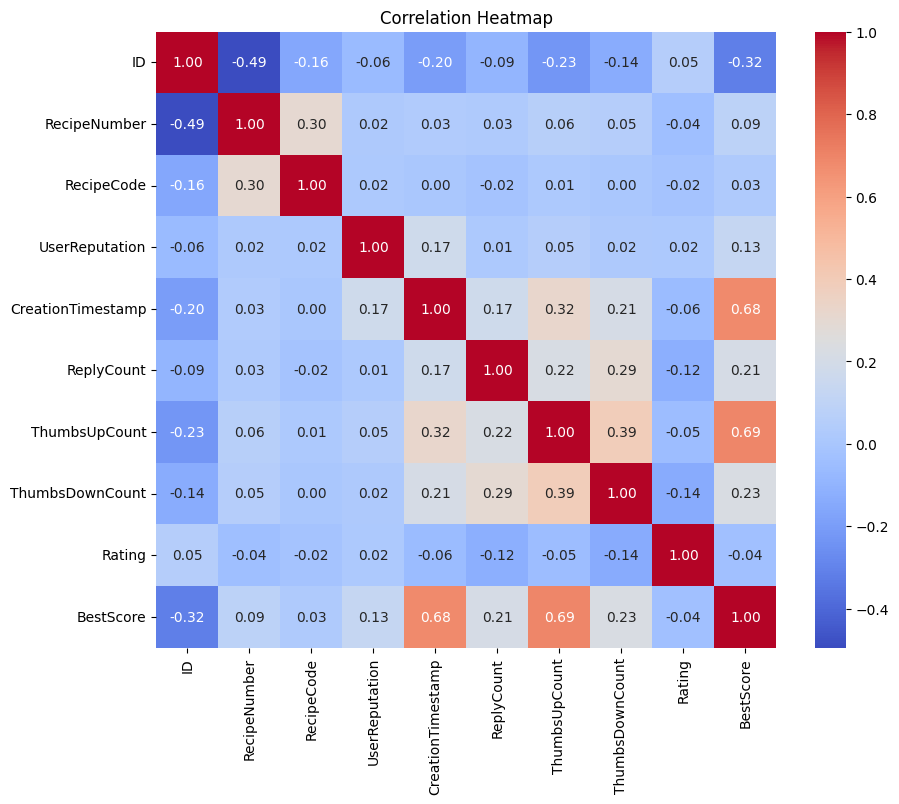

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

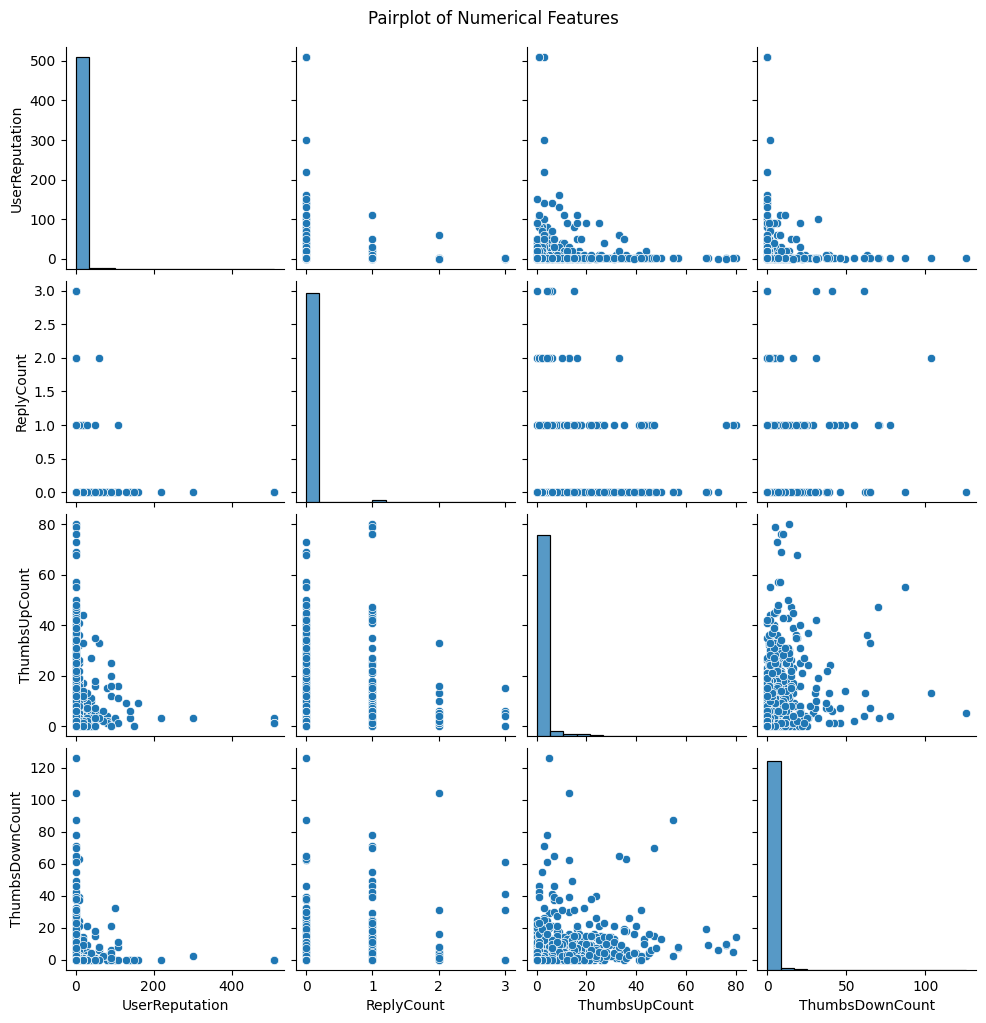

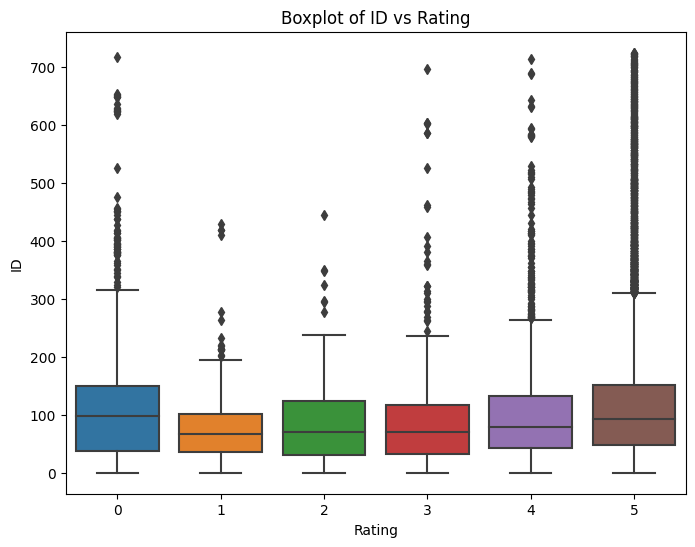

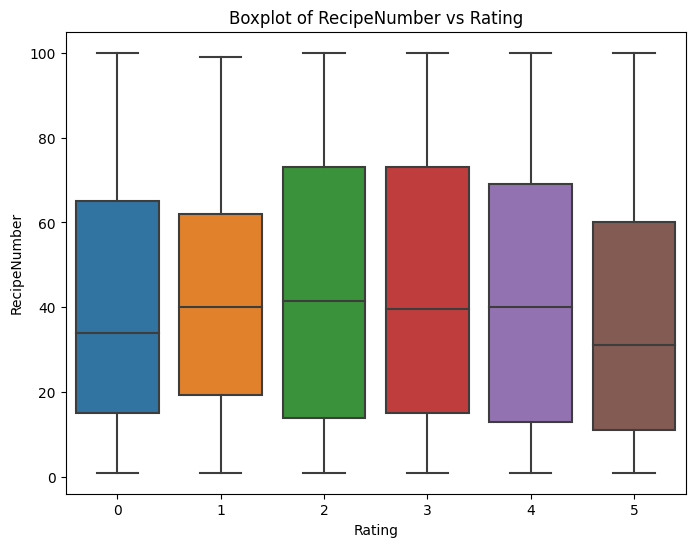

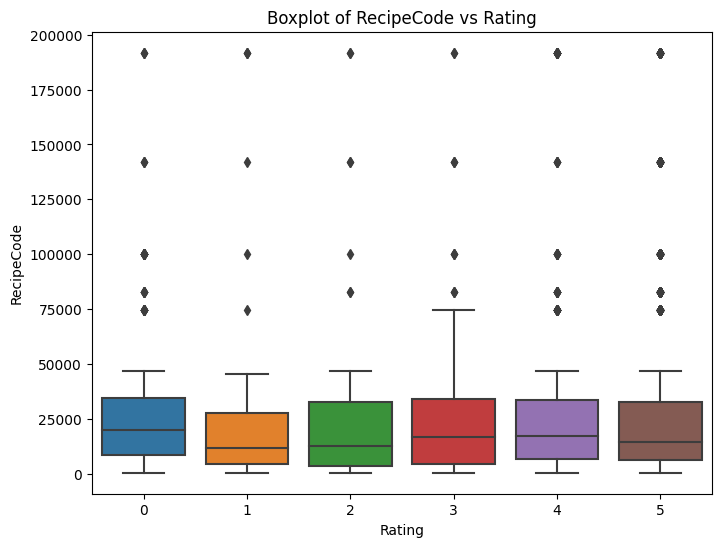

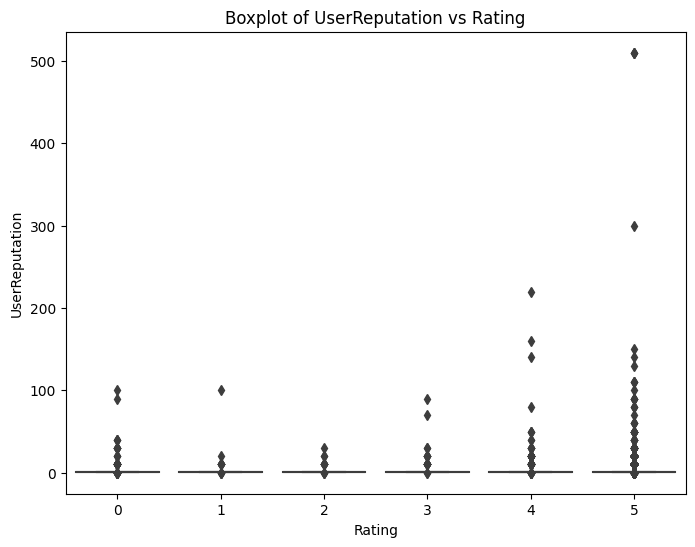

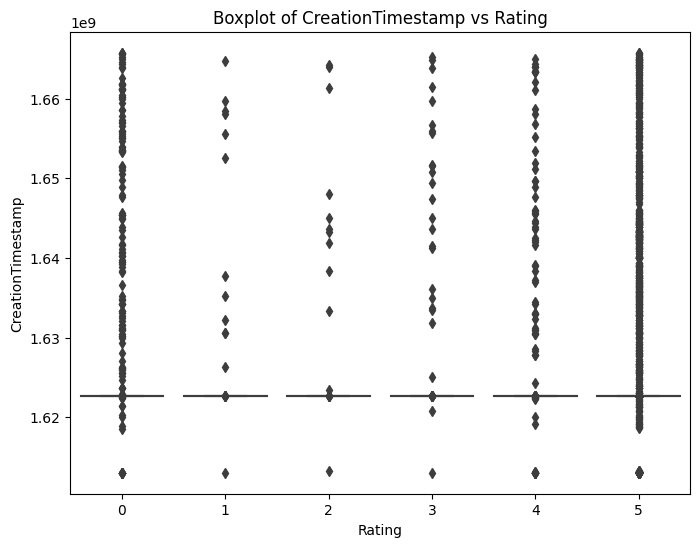

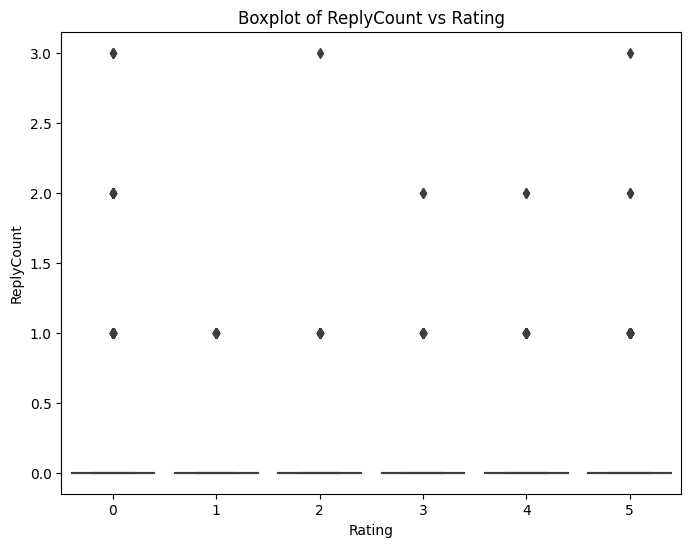

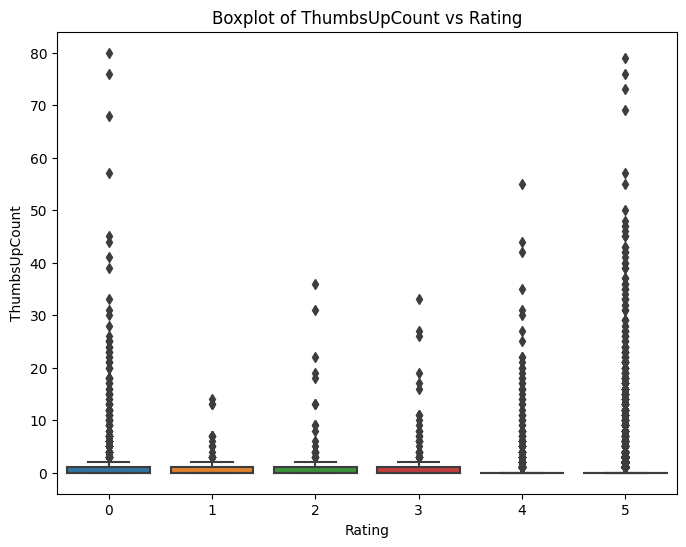

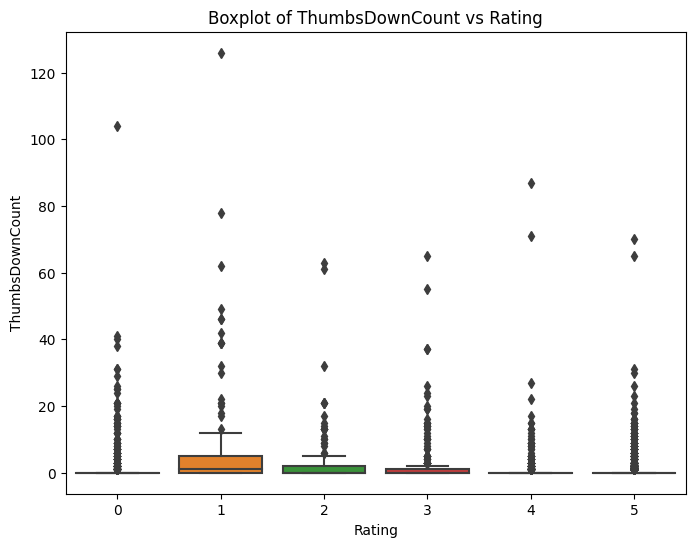

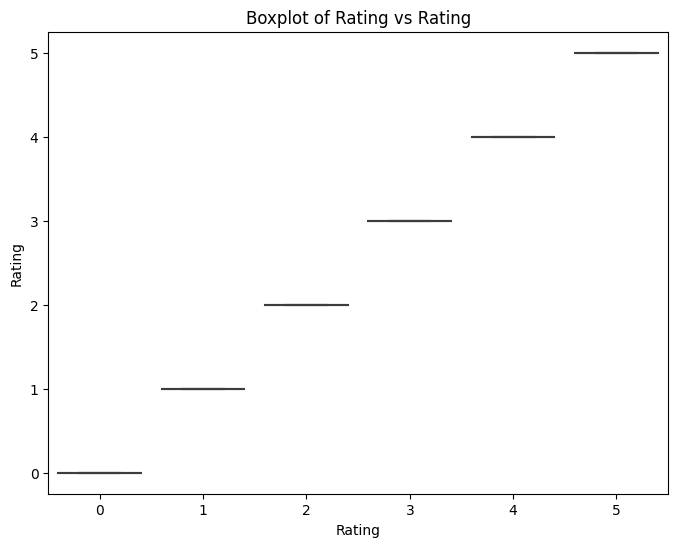

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")

# Drop non-numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Display summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(numerical_data.describe())

# Display correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Display pairplot to visualize relationships between numerical features
sns.pairplot(numerical_data, vars=['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount'], kind='scatter')
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# Display boxplot to visualize relationships between numerical features and target variable
for col in numerical_data.columns[:-1]:  # Excluding the target variable (Rating)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Rating', y=col, data=numerical_data)
    plt.title(f'Boxplot of {col} vs Rating')
    plt.xlabel('Rating')
    plt.ylabel(col)
    plt.show()


In [4]:
# Define preprocessing steps for numerical and categorical features
numeric_features = ['UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['RecipeCode', 'RecipeName', 'UserName', 'Recipe_Review']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [5]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [6]:
# Define the models
models = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression())]),
    'KNN': Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())]),
    'SVM': Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC())]),
    'CART': Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())]),
    'Boosting': Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', AdaBoostClassifier())]),
}

In [7]:
# Define hyperparameters for tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'classifier__penalty': ['l1', 'l2'],
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    'CART': {
        'classifier__max_depth': [3, 5, 7, 9]
    },
    'Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    },
}

In [8]:
# Perform GridSearchCV for hyperparameter tuning
results = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results[model_name] = grid_search


Fitting 5 folds for each of 14 candidates, totalling 70 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [9]:
# Print best hyperparameters for each model
for model_name, result in results.items():
    best_params = result.best_params_
    print("Best Hyperparameters for", model_name, ":", best_params)

Best Hyperparameters for Logistic Regression : {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best Hyperparameters for KNN : {'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best Hyperparameters for SVM : {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best Hyperparameters for CART : {'classifier__max_depth': 3}
Best Hyperparameters for Boosting : {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}


In [10]:
# Train final models with best hyperparameters for each model
final_models = {model_name: result.best_estimator_ for model_name, result in results.items()}
for model_name, model in final_models.items():
    model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Predict ratings for test data using each model
test_predictions = {model_name: model.predict(X_test) for model_name, model in final_models.items()}


In [12]:
# Output results to CSV for each model
for model_name, predictions in test_predictions.items():
    if model_name == 'SVM':
        Ids = np.arange(1, len(predictions) + 1)
        output_df = pd.DataFrame({'ID': Ids ,'Rating': predictions})
        output_df.to_csv(f'predicted_ratings_{model_name}.csv', index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation F1 Score for Logistic Regression : 0.6804576756262359


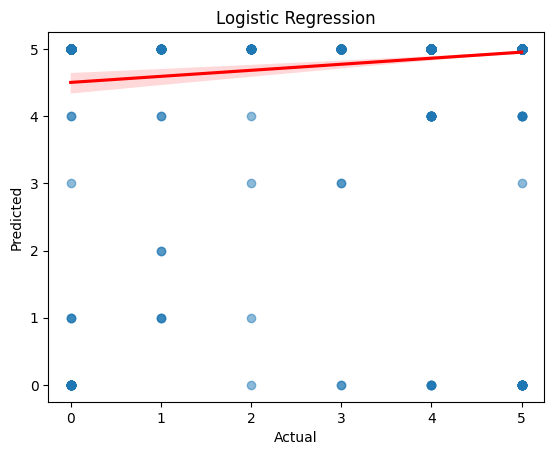

Validation F1 Score for KNN : 0.6774701663459994


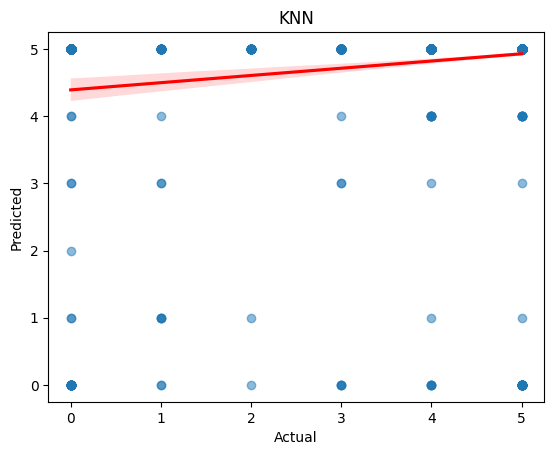

Validation F1 Score for SVM : 0.6859914223038374


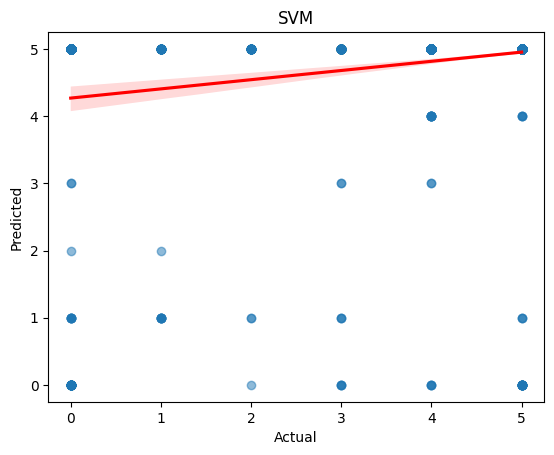

Validation F1 Score for CART : 0.6561081329078667


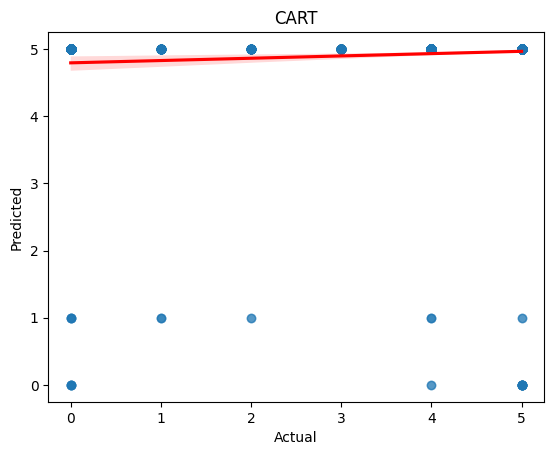

Validation F1 Score for Boosting : 0.6535014125301642


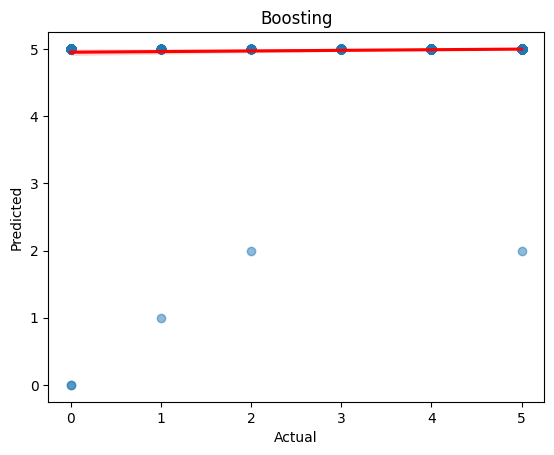

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, RocCurveDisplay, roc_curve

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate and print F1 scores for each model on the validation set
for model_name, model in final_models.items():
    model.fit(X_train_split, y_train_split)
    y_pred_val = model.predict(X_val_split)
    f1 = f1_score(y_val_split, y_pred_val, average='weighted')
    print("Validation F1 Score for", model_name, ":", f1)
    # Plot regression plot
    plt.figure()
    sns.regplot(x=y_val_split, y=y_pred_val, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(model_name)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

1. **User Reputation**: 
   - The average user reputation is around 2.16, with a standard deviation of 10.08, indicating a wide variation in user reputation.
   - User reputation might be an important feature in predicting ratings, as it reflects the credibility or expertise of the user providing the rating.

2. **Interaction Metrics (Reply Count, ThumbsUp Count, ThumbsDown Count)**:
   - These metrics have very low averages (close to zero) and relatively small standard deviations.
   - This suggests that most recipes have few interactions (replies, thumbs up, thumbs down).
   - However, there are significant maximum values, indicating some recipes have garnered substantial attention and feedback.

3. **Rating**:
   - The average rating is approximately 4.29 with a standard deviation of 1.54, indicating a moderate variation in ratings.
   - Most ratings fall between 5 and 0, with a significant proportion being 5. This indicates that most recipes receive high ratings.
   - The minimum rating is 0, which could indicate recipes that were poorly received or had issues.

4. **Best Hyperparameters and Validation F1 Scores**:
   - The hyperparameters and validation F1 scores provide insights into the performance of different models.
   - Logistic Regression, SVM, and KNN models achieved relatively similar F1 scores, indicating comparable performance.
   - Decision Tree (CART) and Boosting models achieved slightly lower F1 scores compared to the other models.
